In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from input_pipeline import dataset_pipeline, get_param_dict
from tqdm import tqdm

2023-10-18 18:41:23.089582: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-18 18:41:23.419278: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-18 18:41:26.315244: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# Dataset

In [2]:
trainset_path = "../GetData/Rust/get_data_rust/Data/Trainset"
testset_path = "../GetData/Rust/get_data_rust/Data/Testset"
batch_size = 100
train_set = dataset_pipeline(trainset_path, flatten=False, batch_size=batch_size)
train_params = get_param_dict(trainset_path)
test_set = dataset_pipeline(testset_path, flatten=False, batch_size=batch_size)
test_params = get_param_dict(testset_path)

print("Trainset parameters: " + str(train_params))
print("Testset parameters: " + str(test_params))

Getting data from ../GetData/Rust/get_data_rust/Data/Trainset
Got 10000 samples
Getting data from ../GetData/Rust/get_data_rust/Data/Testset
Got 1000 samples
Trainset parameters: {'Steps': '1000', 'Simulatiton Number': '10000', 'Temperature': '2.73', 'Magnetic Field': '0', 'Mattize Size': '64'}
Testset parameters: {'Steps': '1000', 'Simulatiton Number': '1000', 'Temperature': '2.73', 'Magnetic Field': '0', 'Mattize Size': '64'}


# Model

In [3]:
class VAE(tf.keras.Model):
  """Variational autoencoder."""

  def __init__(self, latent_dim, kernel_size = 3):
    super(VAE, self).__init__()
    self.latent_dim = latent_dim
    self.encoder = tf.keras.Sequential(
        [
          tf.keras.layers.Conv2D(32, kernel_size, activation='relu', padding="same", input_shape=(64, 64, 1)),
          tf.keras.layers.BatchNormalization(),
          tf.keras.layers.MaxPooling2D((2, 2)),
          tf.keras.layers.Dropout(0.5),
          tf.keras.layers.Conv2D(64, kernel_size, padding="same", activation='relu'),
          tf.keras.layers.BatchNormalization(),
          tf.keras.layers.MaxPooling2D((2, 2)),
          tf.keras.layers.Dropout(0.5),
          tf.keras.layers.Conv2D(64, kernel_size, padding="same", activation='relu'),
          tf.keras.layers.BatchNormalization(),
          tf.keras.layers.Dropout(0.5),
          tf.keras.layers.Flatten(),
          tf.keras.layers.Dense(latent_dim + latent_dim)
        ]
    )

    self.decoder = tf.keras.Sequential(
        [
          tf.keras.layers.InputLayer(input_shape=(latent_dim,)),
          tf.keras.layers.Dense(units=16*16*32, activation=tf.nn.relu),
          tf.keras.layers.Reshape(target_shape=(16, 16, 32)),
          tf.keras.layers.Conv2DTranspose(64, kernel_size, padding="same",activation='relu'),
          tf.keras.layers.UpSampling2D(size=(2, 2)),
          tf.keras.layers.Conv2DTranspose(64, kernel_size, padding="same",activation='relu'),
          tf.keras.layers.UpSampling2D(size=(2, 2)),
          tf.keras.layers.Conv2DTranspose(32, kernel_size, padding="same",activation='relu'),
          tf.keras.layers.Conv2DTranspose(1, kernel_size,  padding="same"),
        ]
    )
  
  @tf.function
  def sample(self, eps=None):
    if eps is None:
      eps = tf.random.normal(shape=(100, self.latent_dim))
    return self.decode(eps, apply_sigmoid=True)

  def encode(self, x):
    mean, logvar = tf.split(self.encoder(x), num_or_size_splits=2, axis=1)
    return mean, logvar

  def reparameterize(self, mean, logvar):
    eps = tf.random.normal(shape=mean.shape)
    return eps * tf.exp(logvar * .5) + mean

  def decode(self, z, apply_sigmoid=False):
    logits = self.decoder(z)
    if apply_sigmoid:
      probs = tf.sigmoid(logits)
      return probs
    return logits
  
def log_normal_pdf(sample, mean, logvar, raxis=1):
  log2pi = tf.math.log(2. * np.pi)
  return tf.reduce_sum(
      -.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi),
      axis=raxis)


def compute_loss(model, x):
  mean, logvar = model.encode(x)
  z = model.reparameterize(mean, logvar)
  x_logit = model.decode(z)
  cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=x)
  logpx_z = -tf.reduce_sum(cross_ent, axis=[1, 2, 3])
  logpz = log_normal_pdf(z, 0., 0.)
  logqz_x = log_normal_pdf(z, mean, logvar)
  return -tf.reduce_mean(logpx_z + logpz - logqz_x)


@tf.function
def train_step(model, x, optimizer):
  """Executes one training step and returns the loss.

  This function computes the loss and gradients, and uses the latter to
  update the model's parameters.
  """
  with tf.GradientTape() as tape:
    loss = compute_loss(model, x)
  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))


# Training

In [4]:
optimizer = tf.keras.optimizers.Adam(1e-4)
epochs = 10
latent_dim = 100
num_examples_to_generate = 5

random_vector_for_generation = tf.random.normal(
    shape=[num_examples_to_generate, latent_dim])

model = VAE(latent_dim)

In [5]:
def plot_spins(path, predictions, originals):
    fig = plt.figure(figsize=(15, 20))
    subfigs = fig.subfigures(nrows=len(predictions), ncols=1)

    for index, subfig in enumerate(subfigs):
        subfig.suptitle(f'Sample nr: {index}')
        axs = subfig.subplots(nrows=1, ncols=4)
        
        axs[0].imshow(predictions[index, :, :, 0], vmin=0, vmax=1)
        axs[0].axis('off')
        axs[0].set_title("Spin +1 probability map")

        axs[1].imshow(np.round(predictions[index, :, :, 0]), vmin=0, vmax=1)
        axs[1].axis('off')
        axs[1].set_title("Predicted spins")

        axs[2].imshow(originals[index, :, :, 0], vmin=0, vmax=1)
        axs[2].axis('off')
        axs[2].set_title("Original Sample")
        
        axs[3].imshow(np.abs(originals[index, :, :, 0] - np.round(predictions[index, :, :, 0])), cmap = 'Reds', vmin=0, vmax=1)
        axs[3].axis('off')
        axs[3].set_title("Difference map")

    plt.savefig(path)
    plt.show()

def generate_and_save_images(model, epoch, test_sample):
  predictions = make_prediction(model, test_sample)
  plot_spins('train_img/image_at_epoch_{:04d}.png'.format(epoch), predictions, test_sample)

def make_prediction(model, test_sample):
    mean, logvar = model.encode(test_sample)
    z = model.reparameterize(mean, logvar)
    predictions = model.sample(z)
    return predictions

In [6]:
# Pick a sample of the test set for generating output images
assert batch_size >= num_examples_to_generate
for test_batch in test_set.take(1):
  test_sample = test_batch[0:num_examples_to_generate, :, :, :]

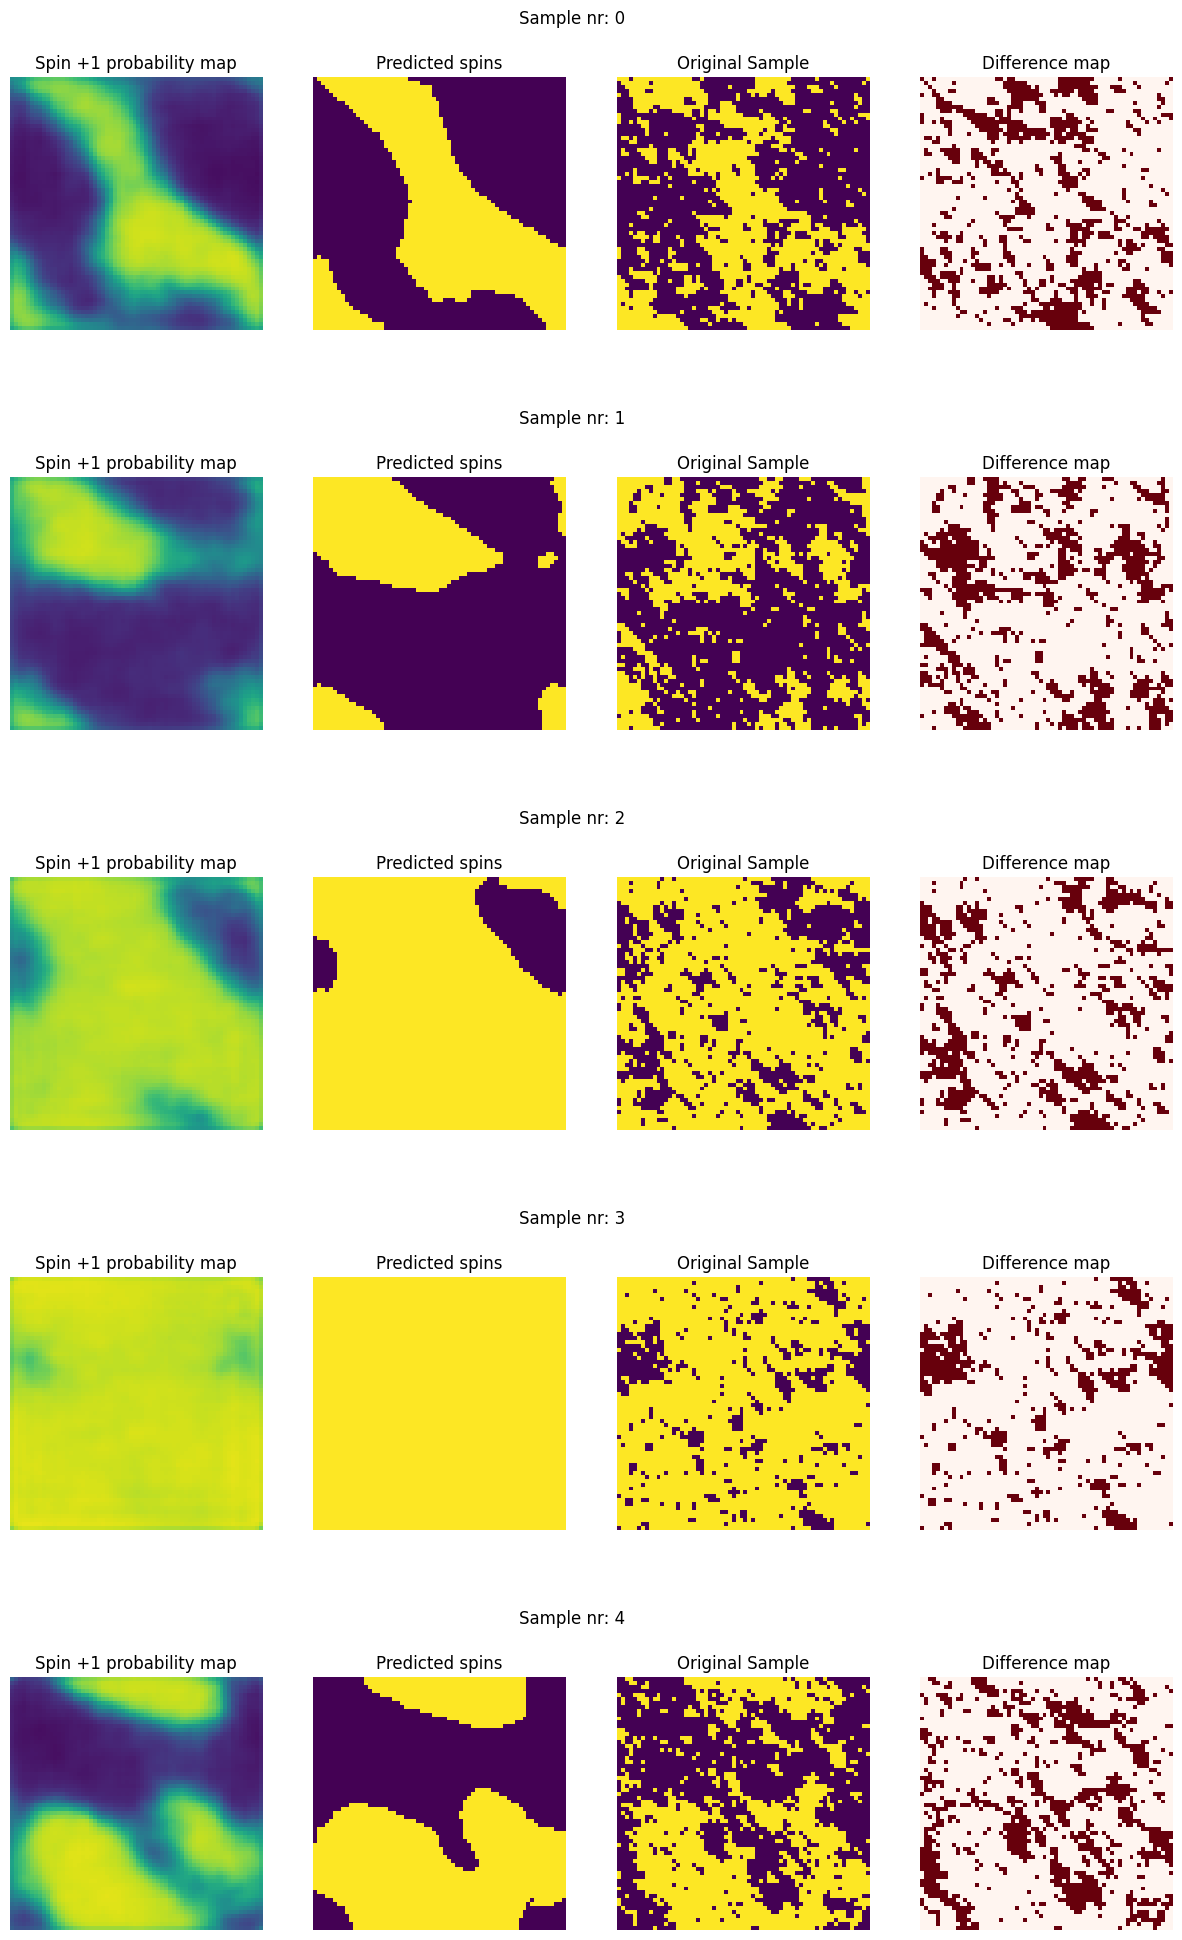

Epoch: 10, Test set ELBO: -2420.07275390625


In [7]:
from IPython import display
loss_list = []
generate_and_save_images(model, 0, test_sample)

for epoch in range(1, epochs + 1):
  for train_x in tqdm(train_set):
    train_step(model, train_x, optimizer)

  loss = tf.keras.metrics.Mean()
  for test_x in test_set:
    loss(compute_loss(model, test_x))
  elbo = -loss.result()
  loss_list.append(loss.result())
  display.clear_output(wait=False)
  generate_and_save_images(model, epoch, test_sample)
  print('Epoch: {}, Test set ELBO: {}'
        .format(epoch, elbo))

Text(0, 0.5, 'Cost function')

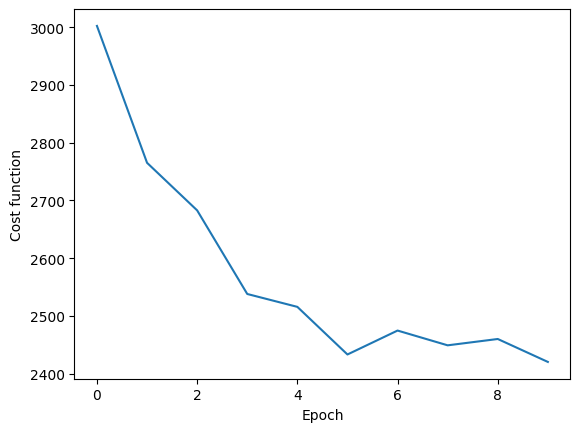

In [8]:
plt.plot(loss_list)
plt.xlabel("Epoch")
plt.ylabel("Cost function")

In [11]:
import glob
import contextlib
from PIL import Image

# filepaths
fp_in = "train_img/*.png"
fp_out = "train_slow.gif"

# use exit stack to automatically close opened images
with contextlib.ExitStack() as stack:

    # lazily load images
    imgs = (stack.enter_context(Image.open(f))
            for f in sorted(glob.glob(fp_in)))

    # extract  first image from iterator
    img = next(imgs)

    # https://pillow.readthedocs.io/en/stable/handbook/image-file-formats.html#gif
    img.save(fp=fp_out, format='GIF', append_images=imgs,
             save_all=True, duration=1000, loop=0)


In [13]:
model.save_weights('models/vae.h5',save_format='h5')